# Revisión de red neuronal

In [1]:
using Gadfly
using Distributions
using Colors

## Funciones relacionadas a la transformación

In [2]:
function logistic(s)
    1/(1+exp(-s))
end

function logisticDerivKnown(x)
    x*(1-x)
end

function logisticDeriv(s)
    logisticDerivKnown(logistic(s))
end

logisticDeriv (generic function with 1 method)

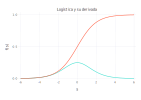

In [3]:
let ss = -6:.1:6,
    fs = [logistic(s) for s in ss],
    ds = [logisticDeriv(s) for s in ss]
    
    plot(
    layer(x=ss, y=fs, Geom.line, 
    Theme(default_color=colorant"tomato", line_width = 2px)
    ),
    
    layer(x=ss, y=ds, Geom.line, 
    Theme(default_color=colorant"turquoise", line_width = 2px)
    ),
    Guide.title("Logística y su derivada"),
    Guide.xlabel("s"), Guide.ylabel("f(s)"))
end

## Estructura de la red

La arquitectura de una red neuronal se describe con un vector columna cuyas entradas son las dimensiones de cada capa consideranto la primer entrada como la dimensión de la capa 0 o capa de entrada.

$$\begin{bmatrix}d^{(0)}\\d^{(1)}\\d^{(2)}\\ \dots \\d^{(L)}\end{bmatrix}$$

$d^{(0)}$ es la cantidad de características (features) de un dato de entrada y $d^{(L)}$ es la cantidad de salidas para un dato.

La red neuronal se compone de un arreglo de capas y cada capa tiene asociada una matriz de pesos.

Para la capa $l$ la matriz de pesos tiene dimensión $\left( d^{(l-1)}+1 \times d^{(l)} \right)$ y las entradas se establecen de manera aleatoria con una distribución uniforme en el intervalo $\left[ -\sqrt{d^{(l-1)}+1}, \sqrt{d^{(l-1)}+1} \right]$ 

In [4]:
type Layer
    weights::Array{Float64,2}
end

type Network
    dimensions::Array{Int64,1}
    layers::Array{Layer,1}
end

function MakeNetwork(dimensions)
    L = length(dimensions)-1
    layers = Array{Layer,1}(L)
    for l in 1:L
        m, n = dimensions[l]+1, dimensions[l+1]
        layers[l] = Layer(rand(Uniform(-sqrt(m),sqrt(m)), (m,n)))
    end
    Network(dimensions, layers)
end

L(net) = eachindex(net.layers)
W(net,l) = net.layers[l].weights

function copyNetwork(net)
    deepcopy(net)
end

copyNetwork (generic function with 1 method)

In [5]:
let dimensions = [2, 3, 1],
    net = MakeNetwork(dimensions)
    
    println("Network layers")
    println("==============")
    for layer in net.layers
        println(layer.weights)
    end
end

Network layers
[-1.2072083562069489 -0.14893368859255762 1.411651472126846
 -0.5210601580290881 1.192163133739144 -0.7061076511261408
 -0.7919182962058406 -0.8109524388158269 -0.9991546797185779]
[-1.6257599071206528
 -1.0613747334792416
 -1.222218804536305
 0.7131807491999895]


## Alimentación hacia adelante

Para alimentar datos hacia adelante la red recibe un vector columna de entradas de dimensión $d^{(0)}$. El valor de retorno es un vector de vectores con las activaciones de cada capa, tal que la activación $L$ es la estimación del valor de salida de la entrada dada.

In [6]:
function forwardPropagation(net::Network, 
                            input::Array{Float64,1})
    activations = Array{Array{Float64,1},1}(length(net.layers))
    x = [1.0; input]
    for l in L(net)
        s = W(net,l)' * x
        map!(logistic, s)
        x = [1.0; s]
        activations[l] = x
    end
    activations 
end

forwardPropagation (generic function with 1 method)

In [7]:
let dimensions = [2, 3, 1],
    net = MakeNetwork(dimensions),
    input = rand(2)
    
    forwardPropagation(net, input)
end

2-element Array{Array{Float64,1},1}:
 [1.0,0.329891,0.0944938,0.568662]
 [1.0,0.708829]                   

## Propagación hacia atrás

La propagación hacia atrás tiene como argumentos un vector de vectores (las activaciones de la red calculadas a partir de la alimentación hacia adelante), un vector columna de dimensión $d^{(0)}$ y un vector columna de salida de dimensión $d^{(L)}$

In [8]:
function backPropagation(net::Network,
                         input::Array{Float64,1},
                         output::Array{Float64,1},
                         X::Array{Array{Float64,1},1})
    deltas = Array{Array{Float64,1},1}(length(net.layers))
    deltas[end] = 2*(X[end][2:end]-output).*map(logisticDerivKnown,X[end][2:end])
    
    for l in L(net)[end-1:-1:1]
        thetaDeriv = map(logisticDerivKnown, X[l][2:end])
        deltas[l] = thetaDeriv .* (W(net,l+1)*deltas[l+1])[2:end]
    end
    deltas
end

function backPropagation(net::Network,
                         input::Array{Float64,1},
                         output::Array{Float64,1})
    X = forwardPropagation(net, input)
    backPropagation(net, input, output, X)
end

backPropagation (generic function with 2 methods)

In [9]:
let dimensions = [1, 2, 1, 1],
    net = MakeNetwork(dimensions),
    input = rand(1),
    output = rand(1)
    
    
    X = forwardPropagation(net, input)
    deltas1 = backPropagation(net, input, output, X)
    deltas2 = backPropagation(net, input, output)
    deltas1 == deltas2
end

true

## Cálculo del gradiente

El cálculo del gradiente de error para un dato de entrada es calculado haciendo alimentación hacia adelante y propagación hacia atrás, el valor de retorno de la función es un vector de matrices, la entrada $l$ de este vector comparte las dimensiones de la matriz de pesos en la capa $l$ de la red neuronal.

In [10]:
function errorGradient(net::Network,
                       input::Array{Float64,1},
                       output::Array{Float64,1},
                       X::Array{Array{Float64,1},1},
                       deltas::Array{Array{Float64,1},1})
    gradEin = Array{Array{Float64,2},1}(length(net.layers))
    gradEin[1] = [1.0; input]*deltas[1]'
    for l in L(net)[2:end]
        gradEin[l] = X[l-1]*deltas[l]'
    end
    gradEin
end

function errorGradient(net::Network,
                       input::Array{Float64,1},
                       output::Array{Float64,1})
    X = forwardPropagation(net, input)
    deltas = backPropagation(net, input, output, X)
    
    errorGradient(net, input, output, X, deltas)
end

errorGradient (generic function with 2 methods)

In [11]:
let dimensions = [1, 2, 1, 1],
    net = MakeNetwork(dimensions),
    input = rand(1),
    output = rand(1)
    
    X = forwardPropagation(net, input)
    deltas = backPropagation(net, input, output, X)
    
    gradEin1 = errorGradient(net, input, output, X, deltas)
    gradEin2 = errorGradient(net, input, output)
    
    gradEin1 == gradEin2
end

true

## Métodos de aprendizaje

### Descenso de gradiente por lotes

Esta es una implementación del descenso de gradiente por lotes. Modifica la red neuronal que recibe como entrada, ajustando los pesos en cada epoch tomando en cuenta a un conjunto de entradas y salidas. El conjunto de datos de entradas es una matriz de dimensiones $(d^{(0)} \times N)$ y el conjunto de datos de salida es una matriz de dimensiones $(d^{(L)} \times N)$, donde $N$ es la cantidad de datos de entrenamiento.

In [12]:
function BGD(net, inputs, outputs, learningRate, epochs)
    N = size(inputs)[2]
    errors = Array{Float64,2}(epochs, size(outputs)[1])
    grad = Array{Array{Float64,2},1}(length(net.layers))
    for l in L(net)
        grad[l] = zeros(W(net,l))
    end
    for epoch in 1:epochs
        e = zeros(outputs[:,1])
        for i in 1:N
            input  = inputs[:,i]
            output = outputs[:,i]
            
            activations = forwardPropagation(net, input)
            estimatedOutput = activations[end][2:end]
            e += (estimatedOutput-output).*(estimatedOutput-output)
            deltas = backPropagation(net, input, output, activations)
            grad += errorGradient(net, input, output, activations, deltas)
        end
        errors[epoch,:] = e/N
        for l in L(net)
            net.layers[l].weights -= learningRate .* grad[l]
            fill!(grad[l], 0.0)
        end
    end
    errors
end

BGD (generic function with 1 method)

#### Visualización del aprendizaje - "Memorización"

Considerando una red neuronal con dimensiones $[1,4,1]$ intentando aprender muestras tomadas de la función seno. Las estimaciones se realizan sobre los mismos datos de entrenamiento.

In [13]:
function visualizeMemorizationProcessBGD(learningRate)
    dimensions = [1, 4, 1]
    net = MakeNetwork(dimensions)
    inputs  = collect(0:0.1:1)'
    outputs = map(x->(sin(2pi*x)+1)/2, inputs)
    N = size(inputs)[2]
    epochs = 1000
    
    # estimation without training
    estimation1 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    # estimations measured each 1000 epochs with training
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation2 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation3 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation4 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation5 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation6 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation7 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation8 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation9 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation10 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation11 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    plot(
    layer(x=inputs, y=estimation11, Geom.line, Theme(default_color = RGBA(1,0,0,1))),
    layer(x=inputs, y=estimation10, Geom.line, Theme(default_color = RGBA(1,.1,0,1))),
    layer(x=inputs, y=estimation9, Geom.line, Theme(default_color = RGBA(1,.2,0,.9))),
    layer(x=inputs, y=estimation8, Geom.line, Theme(default_color = RGBA(1,.3,0,.8))),
    layer(x=inputs, y=estimation7, Geom.line, Theme(default_color = RGBA(1,.4,0,.7))),
    layer(x=inputs, y=estimation6, Geom.line, Theme(default_color = RGBA(1,.5,0,.6))),
    layer(x=inputs, y=estimation5, Geom.line, Theme(default_color = RGBA(1,.6,0,.5))),
    layer(x=inputs, y=estimation4, Geom.line, Theme(default_color = RGBA(1,.7,0,.4))),
    layer(x=inputs, y=estimation3, Geom.line, Theme(default_color = RGBA(1,.8,0,.3))),
    layer(x=inputs, y=estimation2, Geom.line, Theme(default_color = RGBA(1,.9,0,.2))),
    layer(x=inputs, y=estimation1, Geom.line, Theme(default_color = RGBA(1,1,0,.1))),
    layer(x=inputs, y=outputs, Geom.point, Geom.line, Theme(default_color = RGBA(0,0,0,1))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2")
    )
end

visualizeMemorizationProcessBGD (generic function with 1 method)

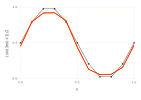

In [14]:
visualizeMemorizationProcessBGD(1.0)

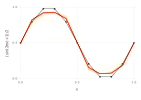

In [15]:
visualizeMemorizationProcessBGD(.5)

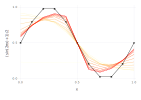

In [16]:
visualizeMemorizationProcessBGD(.1)

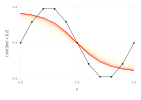

In [17]:
visualizeMemorizationProcessBGD(.01)

#### Analizando el error en muestra a través del tiempo

Ahora se va a comparar los errores en muestra a través de los epochs considerando varios learning rates.

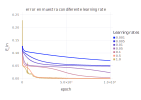

In [18]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRates = [.001, .005, .01, .05, .1, .5, 1]
    epochs = 10000
    
    net1 = copyNetwork(net)
    errors1 = BGD(net1, inputs, outputs, learningRates[1], epochs)
    
    net2 = copyNetwork(net)
    errors2 = BGD(net2, inputs, outputs, learningRates[2], epochs)
    
    net3 = copyNetwork(net)
    errors3 = BGD(net3, inputs, outputs, learningRates[3], epochs)
    
    net4 = copyNetwork(net)
    errors4 = BGD(net4, inputs, outputs, learningRates[4], epochs)
    
    net5 = copyNetwork(net)
    errors5 = BGD(net5, inputs, outputs, learningRates[5], epochs)
    
    net6 = copyNetwork(net)
    errors6 = BGD(net6, inputs, outputs, learningRates[6], epochs)
    
    net7 = copyNetwork(net)
    errors7 = BGD(net7, inputs, outputs, learningRates[7], epochs)
    
    plot(
    layer(x=1:epochs, y=errors1, Geom.line, Theme(line_width=2px, default_color = RGB(0,.1,1))),
    layer(x=1:epochs, y=errors2, Geom.line, Theme(line_width=2px, default_color = RGB(.2,.2,.9))),
    layer(x=1:epochs, y=errors3, Geom.line, Theme(line_width=2px, default_color = RGB(.4,.3,.8))),
    layer(x=1:epochs, y=errors4, Geom.line, Theme(line_width=2px, default_color = RGB(.6,.4,.7))),
    layer(x=1:epochs, y=errors5, Geom.line, Theme(line_width=2px, default_color = RGB(.8,.5,.6))),
    layer(x=1:epochs, y=errors6, Geom.line, Theme(line_width=2px, default_color = RGB(1,.6,.5))),
    layer(x=1:epochs, y=errors7, Geom.line, Theme(line_width=2px, default_color = RGB(.8,.7,.4))),
    
    Guide.title("error en muestra con diferente learning rate"),
    Guide.xlabel("epoch"),
    Guide.ylabel("E_in"),
    Guide.manual_color_key("Learning rates", ["0.001", "0.005", "0.01", "0.05", "0.1", "0.5", "1.0"], [RGB(0,.1,1), RGB(.2,.2,.9), RGB(.4,.3,.8), RGB(.6,.4,.7), RGB(.8,.5,.6), RGB(1,.6,.5), RGB(.8,.7,.4)])
    )
end

Se observa que a partir de los 2500 epochs aproximadamente, los errores con learning rate $0.5$ y $1.0$ son muy parecidos, se elige un learning rate de $0.5$ debido a la estabilidad de los errores en muestra (conforme aumentan las epochs un learning rate de $1.0$ tiene errores que oscilan alrededor de los errores con learning rate de $0.5$.

Se puede hacer una mejor aproximación si consideramos learning rates entre $0.4$ y $1.0$ para observar mejor el comportamiento de estas oscilaciones y a su vez, elegir un mejor learning rate para este problema en particular.

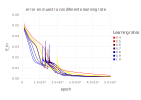

In [19]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRates = [.4, .5, .6, .7, .8, .9, 1.0],
    epochs = 5000
    
    net1 = copyNetwork(net)
    errors1 = BGD(net1, inputs, outputs, learningRates[1], epochs)
    
    net2 = copyNetwork(net)
    errors2 = BGD(net2, inputs, outputs, learningRates[2], epochs)
    
    net3 = copyNetwork(net)
    errors3 = BGD(net3, inputs, outputs, learningRates[3], epochs)
    
    net4 = copyNetwork(net)
    errors4 = BGD(net4, inputs, outputs, learningRates[4], epochs)
    
    net5 = copyNetwork(net)
    errors5 = BGD(net5, inputs, outputs, learningRates[5], epochs)
    
    net6 = copyNetwork(net)
    errors6 = BGD(net6, inputs, outputs, learningRates[6], epochs)
    
    net7 = copyNetwork(net)
    errors7 = BGD(net7, inputs, outputs, learningRates[7], epochs)
    
    plot(
    layer(x=100:epochs, y=errors1[100:end], Geom.line, Theme(default_color = RGB(1  ,0,0  ))),
    layer(x=100:epochs, y=errors2[100:end], Geom.line, Theme(line_width=2px,default_color = RGB(1,1,0  ))),
    layer(x=100:epochs, y=errors3[100:end], Geom.line, Theme(default_color = RGB(.5 ,0,0  ))),
    layer(x=100:epochs, y=errors4[100:end], Geom.line, Theme(default_color = RGB(.25,0,.25))),
    layer(x=100:epochs, y=errors5[100:end], Geom.line, Theme(default_color = RGB(0  ,0,.5 ))),
    layer(x=100:epochs, y=errors6[100:end], Geom.line, Theme(default_color = RGB(0  ,0,.75))),
    layer(x=100:epochs, y=errors7[100:end], Geom.line, Theme(default_color = RGB(0  ,0,1  ))),
    
    Guide.title("error en muestra con diferente learning rate"),
    Guide.xlabel("epoch"),
    Guide.ylabel("E_in"),
    Guide.manual_color_key("Learning rates", ["0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], [RGB(1,0,0), RGB(.75,0,0), RGB(.5,0,0), RGB(.25,0,.25), RGB(0,0,.5), RGB(0,0,.75), RGB(0,0,1)])
    )
end

En la gráfica anterior se pintó en amarillo con línea gruesa la curva del learning rate $0.5$, optaré por usar un learning rate de $0.4$ para este problema, con este algoritmo ya que parece ser una curva mas suave, lo cual me indica que el tamaño de paso en el descenso de gradiente por lotes es lo suficientemente pequeño como para no aumentar el error repentinamente. Cabe aclarar que estas observaciones son limitadas debido a mi conocimiento sobre estas técnicas.

A continuación se muestra la *memorización* de esta red neuronal utilizando un learning rate de $0.4$

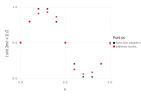

In [20]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRate = .4,
    epochs = 5000
    
    BGD(net, inputs, outputs, learningRate, epochs)
    estimation = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    
    plot(
    layer(x=inputs, y=estimation, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=inputs, y=outputs, Geom.point, Theme(default_color = RGB(0,0,0))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("Puntos", ["función objetivo", "estimaciones"], [RGB(0,0,0), RGB(1,0,0)])
    )
end

#### Visualización del aprendizaje - "Generalización"

Considerando una red neuronal con dimensiones $[1,4,1]$ intentando aprender muestras tomadas de la función seno. Las estimaciones se realizan sobre datos generados de manera uniforme en $[0,1]$, la cantidad de datos generados es diez veces la cantidad de datos de entrenamiento.

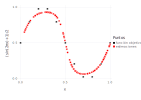

In [21]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRate = .4,
    epochs = 5000
    
    BGD(net, inputs, outputs, learningRate, epochs)
    
    unknowns = rand(Uniform(0,1),10*N)'
    estimation = [forwardPropagation(net, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    
    plot(
    layer(x=unknowns, y=estimation, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=inputs, y=outputs, Geom.point, Theme(default_color = RGB(0,0,0))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("Puntos", ["función objetivo", "estimaciones"], [RGB(0,0,0), RGB(1,0,0)])
    )
end

Podemos extrapolar estos puntos para obtener una curva parecida a la hipótesis que aprendió la red neuronal. 

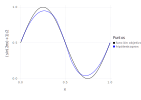

In [22]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRate = .4,
    epochs = 5000
    
    BGD(net, inputs, outputs, learningRate, epochs)
    
    unknowns = rand(Uniform(0,1),10*N)'
    estimation = [forwardPropagation(net, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    
    plot(
    layer(x=unknowns, y=estimation, Geom.smooth, Theme(default_color = RGB(0,0,1))),
    layer(x->(sin(2pi*x)+1)/2, 0, 1, Theme(default_color = RGB(0,0,0))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("Puntos", ["función objetivo", "hipótesis aprox"], [RGB(0,0,0), RGB(0,0,1)])
    )
end

### Descenso de gradiente estocástico

Ahora consideramos un algorítmo estadísticamente mejor que el descenso de gradiente por lotes. En lugar de actualizar los pesos con el promedio de los gradientes de cada elemento en el conjunto de datos de entrenamiento, lo que se hace es elegir un dato de entrenamiento al azar y actualizar el valor de los pesos con el gradiente del error en muestra asociado al dato.

In [23]:
function SGD(net, inputs, outputs, learningRate, epochs)
    N = size(inputs)[2]
    errors = Array{Float64,2}(epochs, size(outputs)[1])
    grad = Array{Array{Float64,2},1}(length(net.layers))
    for l in L(net)
        grad[l] = zeros(W(net,l))
    end
    for epoch in 1:epochs
        i = rand(1:N)
        input  = inputs[:,i]
        output = outputs[:,i]
        
        activations = forwardPropagation(net, input)
        estimatedOutput = activations[end][2:end]
        e = (estimatedOutput-output).*(estimatedOutput-output)
        deltas = backPropagation(net, input, output, activations)
        grad += errorGradient(net, input, output, activations, deltas)
        
        errors[epoch,:] = e/N
        for l in L(net)
            net.layers[l].weights -= learningRate .* grad[l]
            fill!(grad[l], 0.0)
        end
    end
    errors
end

SGD (generic function with 1 method)

In [24]:
function visualizeMemorizationProcessSGD(learningRate)
    dimensions = [1, 4, 1]
    net = MakeNetwork(dimensions)
    inputs  = collect(0:0.1:1)'
    outputs = map(x->(sin(2pi*x)+1)/2, inputs)
    N = size(inputs)[2]
    epochs = 1000
    
    # estimation without training
    estimation1 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    # estimations measured each 1000 epochs with training
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation2 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation3 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation4 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation5 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation6 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation7 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation8 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation9 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation10 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    SGD(net, inputs, outputs, learningRate, epochs)
    estimation11 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    plot(
    layer(x=inputs, y=estimation11, Geom.line, Theme(default_color = RGBA(1,0,0,1))),
    layer(x=inputs, y=estimation10, Geom.line, Theme(default_color = RGBA(1,.1,0,1))),
    layer(x=inputs, y=estimation9, Geom.line, Theme(default_color = RGBA(1,.2,0,.9))),
    layer(x=inputs, y=estimation8, Geom.line, Theme(default_color = RGBA(1,.3,0,.8))),
    layer(x=inputs, y=estimation7, Geom.line, Theme(default_color = RGBA(1,.4,0,.7))),
    layer(x=inputs, y=estimation6, Geom.line, Theme(default_color = RGBA(1,.5,0,.6))),
    layer(x=inputs, y=estimation5, Geom.line, Theme(default_color = RGBA(1,.6,0,.5))),
    layer(x=inputs, y=estimation4, Geom.line, Theme(default_color = RGBA(1,.7,0,.4))),
    layer(x=inputs, y=estimation3, Geom.line, Theme(default_color = RGBA(1,.8,0,.3))),
    layer(x=inputs, y=estimation2, Geom.line, Theme(default_color = RGBA(1,.9,0,.2))),
    layer(x=inputs, y=estimation1, Geom.line, Theme(default_color = RGBA(1,1,0,.1))),
    layer(x=inputs, y=outputs, Geom.point, Geom.line, Theme(default_color = RGBA(0,0,0,1))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2")
    )
end

visualizeMemorizationProcessSGD (generic function with 1 method)

#### Visualización del aprendizaje - "Memorización"

Ahora se considerará una red neuronal con las mismas dimensiones que hemos estado trabajando, pero se utilizará el método de descenso de gradiente estocástico para entrenar la red.

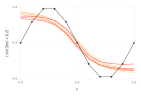

In [25]:
visualizeMemorizationProcessSGD(.4)

Como se logra apreciar, las estimaciones realizadas son pobres a comparación del descenso de gradiente en lotes utilizando el mismo learning rate. La estimación del SGD parece una versión menos suave que la estimación realizada por el BGD con learning rate de $0.01$, solo que el entrenamiento se realizó en menor tiempo. Podemos hacer una comparativa rápida del tiempo de ejecución para comparar.

BGD last error         0.0540301854897332
SGD last error         8.634398318167832e-5
--------------
BGD training duration  1.491162458 seconds
SGD training duration  0.142084354 seconds


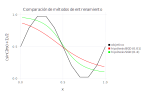

In [26]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 5000
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.01, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 0.4, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.line, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.line, Theme(default_color = RGB(0,1,0))),
    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0)])
    )
    
    
    println("BGD last error         $(errorsBGD[end])")
    println("SGD last error         $(errorsSGD[end])")
    println("--------------")
    println("BGD training duration  $(timeBGD) seconds")
    println("SGD training duration  $(timeSGD) seconds")
    
    sleep(.5)
    
    p
end

Podemos notar que un learning rate de $0.4$ es bastante malo para el descenso de gradiente estocástico. Podemos hacer el mismo análisis que con BGD para elegir un mejor valor para este parámetro.

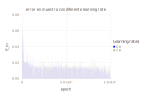

In [27]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    learningRates = [5, 7]
    epochs = 10000
    
    net1 = copyNetwork(net)
    errors1 = SGD(net1, inputs, outputs, learningRates[1], epochs)
    
    net2 = copyNetwork(net)
    errors2 = SGD(net2, inputs, outputs, learningRates[2], epochs)
    
    plot(
    layer(x=1:epochs, y=errors1, Geom.line, Theme(line_width=1px, default_color = RGBA(0,.1,1, .1))),
    layer(x=1:epochs, y=errors2, Geom.line, Theme(line_width=1px, default_color = RGBA(.8,.7,.4, .1))),
    
    Guide.title("error en muestra con diferente learning rate"),
    Guide.xlabel("epoch"),
    Guide.ylabel("E_in"),
    Guide.manual_color_key("Learning rates", ["5.0", "7.0"], [RGB(0,.1,1), RGB(.8,.7,.4)])
    )
end

Como se puede apreciar, el error en muestra disminuye bastante rápido, después de revisar valores en el rango $[0.5, 50]$ determiné que un learning rate de $5$ puede ser utilizado para entrenar esta red con SGD.

BGD last error         0.0021066690185202706
SGD last error         0.00037648722307743034
--------------
BGD training duration  1.507214233 seconds
SGD training duration  0.15018453 seconds


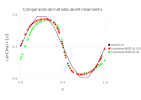

In [28]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 5000
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0)])
    )
    
    
    println("BGD last error         $(errorsBGD[end])")
    println("SGD last error         $(errorsSGD[end])")
    println("--------------")
    println("BGD training duration  $(timeBGD) seconds")
    println("SGD training duration  $(timeSGD) seconds")
    
    sleep(.5)
    
    p
end

Debido a que el SGD es un orden de magnitud mas rápido que el BGD, podemos darnos el lujo de invertir mas epochs en el proceso.

BGD last error         0.001086092021792824
SGD last error         0.0002411441049348124
--------------
BGD training duration  15.023811169 seconds
SGD training duration  2.261225807 seconds


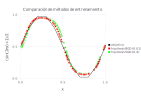

In [29]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 50000
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0)])
    )
    
    
    println("BGD last error         $(errorsBGD[end])")
    println("SGD last error         $(errorsSGD[end])")
    println("--------------")
    println("BGD training duration  $(timeBGD) seconds")
    println("SGD training duration  $(timeSGD) seconds")
    
    sleep(.5)
    
    p
end

In [30]:
function batchGradient(net::Network,
                       inputs,
                       outputs)
    N = size(inputs)[2]
    grad = Array{Array{Float64,2},1}(length(net.layers))
    for l in L(net)
        grad[l] = zeros(W(net,l))
    end
    e = zeros(outputs[:,1])
    for i in 1:N
        input = inputs[:,i]
        output = outputs[:,i]
        activations = forwardPropagation(net, input)
        estimatedOutput = activations[end][2:end]
        diff = estimatedOutput-output
        e += diff.*diff
        grad += errorGradient(net, input, output, activations, backPropagation(net, input, output, activations))
    end
    (e/N, grad)
end

batchGradient (generic function with 1 method)

In [31]:
function RPROP(net::Network,
               inputs,
               outputs,
               epochs)
    N = size(inputs)[2]
    errors = Array{Float64,2}(epochs, size(outputs)[1])
    δEprev = Array{Array{Float64,2},1}(length(net.layers))
    Δ      = Array{Array{Float64,2},1}(length(net.layers))
    for l in L(net)
        δEprev[l] = zeros(W(net,l))
        Δ[l]      = ones(W(net,l)).*0.1
    end

    for epoch in 1:epochs
        error, δE = batchGradient(net, inputs, outputs)
        errors[epoch,:] = error
        # Update
        for l in L(net)
            w = net.layers[l].weights
            m, n = size(w)
            for i in 1:m
                for j in 1:n
                    δsign = sign(δEprev[l][i,j]*δE[l][i,j])
                    if δsign == 1
                        Δ[l][i,j] = min(Δ[l][i,j]*1.2, 50.0)
                        w[i,j] = w[i,j]-sign(δE[l][i,j])*Δ[l][i,j]
                        δEprev[l][i,j] = δE[l][i,j]
                    elseif δsign == -1
                        Δ[l][i,j] = max(Δ[l][i,j]*0.5, 1e-6)
                        δEprev[l][i,j] = 0.0
                    elseif δsign == 0
                        w[i,j] = w[i,j]-sign(δE[l][i,j])*Δ[l][i,j]
                        δEprev[l][i,j] = δE[l][i,j]
                    end
                end
            end
        end    
    end
    errors
end

RPROP (generic function with 1 method)

In [32]:
function visualizeMemorizationProcessRPROP()
    dimensions = [1, 4, 1]
    net = MakeNetwork(dimensions)
    inputs  = collect(0:0.1:1)'
    outputs = map(x->(sin(2pi*x)+1)/2, inputs)
    N = size(inputs)[2]
    epochs = 1000
    
    # estimation without training
    estimation1 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    # estimations measured each 1000 epochs with training
    RPROP(net, inputs, outputs, epochs)
    estimation2 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation3 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation4 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation5 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation6 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation7 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation8 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation9 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation10 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    RPROP(net, inputs, outputs, epochs)
    estimation11 = [forwardPropagation(net, inputs[:,i])[end][2] for i in 1:N]'
    
    plot(
    layer(x=inputs, y=estimation11, Geom.line, Theme(default_color = RGBA(1,0,0,1))),
    layer(x=inputs, y=estimation10, Geom.line, Theme(default_color = RGBA(1,.1,0,1))),
    layer(x=inputs, y=estimation9, Geom.line, Theme(default_color = RGBA(1,.2,0,.9))),
    layer(x=inputs, y=estimation8, Geom.line, Theme(default_color = RGBA(1,.3,0,.8))),
    layer(x=inputs, y=estimation7, Geom.line, Theme(default_color = RGBA(1,.4,0,.7))),
    layer(x=inputs, y=estimation6, Geom.line, Theme(default_color = RGBA(1,.5,0,.6))),
    layer(x=inputs, y=estimation5, Geom.line, Theme(default_color = RGBA(1,.6,0,.5))),
    layer(x=inputs, y=estimation4, Geom.line, Theme(default_color = RGBA(1,.7,0,.4))),
    layer(x=inputs, y=estimation3, Geom.line, Theme(default_color = RGBA(1,.8,0,.3))),
    layer(x=inputs, y=estimation2, Geom.line, Theme(default_color = RGBA(1,.9,0,.2))),
    layer(x=inputs, y=estimation1, Geom.line, Theme(default_color = RGBA(1,1,0,.1))),
    layer(x=inputs, y=outputs, Geom.point, Geom.line, Theme(default_color = RGBA(0,0,0,1))),
    
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2")
    )
end

visualizeMemorizationProcessRPROP (generic function with 1 method)

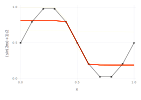

In [33]:
visualizeMemorizationProcessRPROP()

BGD last error          0.00246406674717814
SGD last error          2.5335974868027345e-5
RPROP last error        0.02750586394462888
--------------
BGD training duration   1.476903747 seconds
SGD training duration   0.135399009 seconds
RPROP training duration 1.470760399 seconds


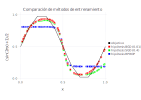

In [34]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 5000
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netRPROP = copyNetwork(net)
    tic()
    errorsRPROP = RPROP(netRPROP, inputs, outputs, epochs)
    timeRPROP = toq()
    estimationRPROP = [forwardPropagation(netRPROP, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    layer(x=unknowns, y=estimationRPROP, Geom.point, Theme(default_color = RGB(0,0,1))),

    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)", "hipótesis RPROP"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0),RGB(0,0,1)])
    )
    
    
    println("BGD last error          $(errorsBGD[end])")
    println("SGD last error          $(errorsSGD[end])")
    println("RPROP last error        $(errorsRPROP[end])")
    println("--------------")
    println("BGD training duration   $(timeBGD) seconds")
    println("SGD training duration   $(timeSGD) seconds")
    println("RPROP training duration $(timeRPROP) seconds")
    
    sleep(.5)
    
    p
end

BGD last error          0.047166582364005456
SGD last error          0.004819831717931935
RPROP last error        0.019977450606865586
--------------
BGD training duration   0.14728913 seconds
SGD training duration   0.012371101 seconds
RPROP training duration 0.145947845 seconds


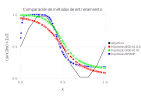

In [35]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 500
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netRPROP = copyNetwork(net)
    tic()
    errorsRPROP = RPROP(netRPROP, inputs, outputs, epochs)
    timeRPROP = toq()
    estimationRPROP = [forwardPropagation(netRPROP, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    layer(x=unknowns, y=estimationRPROP, Geom.point, Theme(default_color = RGB(0,0,1))),

    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)", "hipótesis RPROP"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0),RGB(0,0,1)])
    )
    
    
    println("BGD last error          $(errorsBGD[end])")
    println("SGD last error          $(errorsSGD[end])")
    println("RPROP last error        $(errorsRPROP[end])")
    println("--------------")
    println("BGD training duration   $(timeBGD) seconds")
    println("SGD training duration   $(timeSGD) seconds")
    println("RPROP training duration $(timeRPROP) seconds")
    
    sleep(.5)
    
    p
end

BGD last error          0.05193037269150658
SGD last error          0.004267166298756935
RPROP last error        0.024943355729900453
--------------
BGD training duration   0.05293806 seconds
SGD training duration   0.004284835 seconds
RPROP training duration 0.047430972 seconds


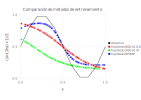

In [36]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 100
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netRPROP = copyNetwork(net)
    tic()
    errorsRPROP = RPROP(netRPROP, inputs, outputs, epochs)
    timeRPROP = toq()
    estimationRPROP = [forwardPropagation(netRPROP, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    layer(x=unknowns, y=estimationRPROP, Geom.point, Theme(default_color = RGB(0,0,1))),

    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)", "hipótesis RPROP"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0),RGB(0,0,1)])
    )
    
    
    println("BGD last error          $(errorsBGD[end])")
    println("SGD last error          $(errorsSGD[end])")
    println("RPROP last error        $(errorsRPROP[end])")
    println("--------------")
    println("BGD training duration   $(timeBGD) seconds")
    println("SGD training duration   $(timeSGD) seconds")
    println("RPROP training duration $(timeRPROP) seconds")
    
    sleep(.5)
    
    p
end

BGD last error          0.06570776419114065
SGD last error          0.03819316662379549
RPROP last error        0.045696339305128036
--------------
BGD training duration   0.014869302 seconds
SGD training duration   0.001221216 seconds
RPROP training duration 0.021256263 seconds


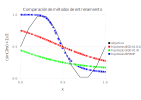

In [37]:
let dimensions = [1, 4, 1],
    net = MakeNetwork(dimensions),
    inputs  = collect(0:0.1:1)',
    outputs = map(x->(sin(2pi*x)+1)/2, inputs),
    N = size(inputs)[2],
    epochs = 50
    
    unknowns = rand(Uniform(0,1),10*N)'
    
    netBGD = copyNetwork(net)
    tic()
    errorsBGD = BGD(netBGD, inputs, outputs, 0.4, epochs)
    timeBGD = toq()
    estimationBGD = [forwardPropagation(netBGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netSGD = copyNetwork(net)
    tic()
    errorsSGD = SGD(netSGD, inputs, outputs, 5.0, epochs)
    timeSGD = toq()
    estimationSGD = [forwardPropagation(netSGD, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    netRPROP = copyNetwork(net)
    tic()
    errorsRPROP = RPROP(netRPROP, inputs, outputs, epochs)
    timeRPROP = toq()
    estimationRPROP = [forwardPropagation(netRPROP, unknowns[:,i])[end][2] for i in 1:10*N]'
    
    p = plot(
    layer(x=inputs, y=outputs, Geom.line, Theme(default_color = RGB(0,0,0))),
    layer(x=unknowns, y=estimationBGD, Geom.point, Theme(default_color = RGB(1,0,0))),
    layer(x=unknowns, y=estimationSGD, Geom.point, Theme(default_color = RGB(0,1,0))),
    layer(x=unknowns, y=estimationRPROP, Geom.point, Theme(default_color = RGB(0,0,1))),

    Guide.title("Comparación de métodos de entrenamiento"),
    Guide.xlabel("x"),
    Guide.ylabel("(sin(2πx)+1)/2"),
    Guide.manual_color_key("", ["objetivo", "hipótesis BGD (0.01)", "hipótesis SGD (0.4)", "hipótesis RPROP"], [RGB(0,0,0),RGB(1,0,0),RGB(0,1,0),RGB(0,0,1)])
    )
    
    
    println("BGD last error          $(errorsBGD[end])")
    println("SGD last error          $(errorsSGD[end])")
    println("RPROP last error        $(errorsRPROP[end])")
    println("--------------")
    println("BGD training duration   $(timeBGD) seconds")
    println("SGD training duration   $(timeSGD) seconds")
    println("RPROP training duration $(timeRPROP) seconds")
    
    sleep(.5)
    
    p
end